In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path

In [2]:
DATA_FOLDER = Path("../input/fruits/fruits-360_dataset/fruits-360")
TRAIN = DATA_FOLDER / 'Training'

In [3]:
for i,fruit_class in enumerate(TRAIN.iterdir()):
    print(fruit_class.stem)
    if i > 5: break

Quince
Grapefruit White
Granadilla
Orange
Apple Red 3
Grape White 2
Corn Husk


In [4]:
from tqdm import tqdm
from PIL import Image
import random

def load_data(path, sample=30, shuffle=True, get_class=None):
    res = []
    for fruit_class in tqdm(path.iterdir()):
        if get_class:
            if fruit_class.stem != get_class: continue
        for i,image in enumerate(fruit_class.iterdir()):
            res.append((np.array(Image.open(image)),
                        fruit_class.stem,
                        image.stem))
            if i > sample:
                break
    if shuffle:
        random.shuffle(res)
            
    return res

train = load_data(TRAIN)
# load_data(TRAIN,get_class='Eggplant')

131it [00:44,  2.96it/s]


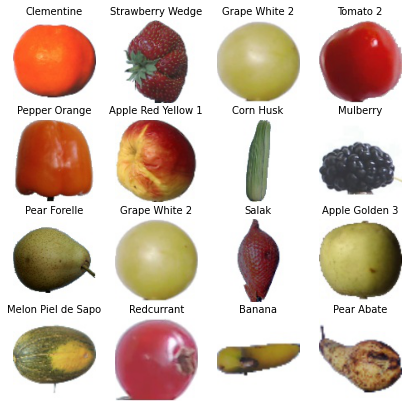

In [5]:
fig,axes = plt.subplots(4,4,figsize=(7,7))
imgs,labels,fnames = zip(*train)

for img,label,fname,ax in zip(imgs,labels,fnames,axes.ravel()):
    plt.sca(ax)
    plt.imshow(img)
    plt.axis('off')
    plt.title(label, fontsize=10)
plt.show()

In [6]:
import copy
labels_copy = list(set(copy.deepcopy(labels)))
random.shuffle(labels_copy)
selected_labels = labels_copy[:20]

In [7]:
labels[:10]

('Clementine',
 'Strawberry Wedge',
 'Grape White 2',
 'Tomato 2',
 'Pepper Orange',
 'Apple Red Yellow 1',
 'Corn Husk',
 'Mulberry',
 'Pear Forelle',
 'Grape White 2')

In [8]:
from collections import defaultdict
acc = defaultdict(list)
for image, label in zip(imgs,labels):
    if label in selected_labels:
        acc[label].append(image.mean((0,1),where=image!=255))

acc = {k:np.array(v) for k,v in acc.items()}

In [9]:
acc.keys()

dict_keys(['Clementine', 'Melon Piel de Sapo', 'Redcurrant', 'Grape White', 'Apple Golden 2', 'Pear', 'Banana Lady Finger', 'Pear Williams', 'Pepper Yellow', 'Onion Red Peeled', 'Potato Red', 'Avocado', 'Beetroot', 'Pear Monster', 'Orange', 'Apricot', 'Eggplant', 'Passion Fruit', 'Apple Red 2', 'Nectarine'])

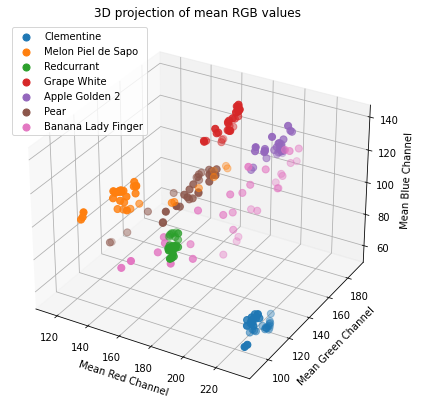

In [10]:
import matplotlib.pyplot as plt
import random

def unstack(a, axis = 0):
    return [np.squeeze(e, axis) for e in np.split(a, a.shape[axis], axis = axis)]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')

for i,( name, rgb_vals ) in enumerate(acc.items()):
    if i > 6: break
    r,g,b = unstack(rgb_vals,1)
    c = np.array([r,g,b]).T / 255.
    ax.scatter(
        r,g,b,
        s = 50,
#         c = c,
        label=name
    )
    plt.xlabel('Mean Red Channel')
    plt.ylabel('Mean Green Channel')
    ax.set_zlabel('Mean Blue Channel')
    
plt.title('3D projection of mean RGB values', 
)
plt.legend()
plt.show()

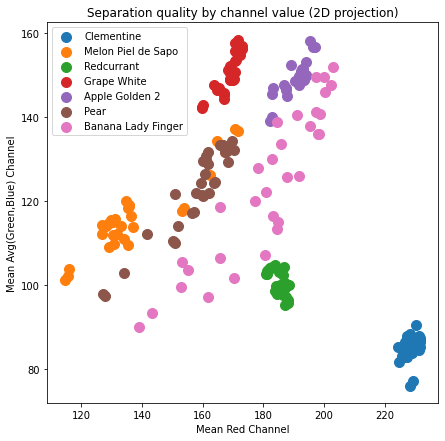

In [11]:
import matplotlib.pyplot as plt
import random

def unstack(a, axis = 0):
    return [np.squeeze(e, axis) for e in np.split(a, a.shape[axis], axis = axis)]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

for i,( name, rgb_vals ) in enumerate(acc.items()):
    if i > 6: break
    r,g,b = unstack(rgb_vals,1)
    c = np.array([r,g,b]).T / 255.
    ax.scatter(
        r,(g+b)/2,
#         c = c,
        s = 100,
        label=name
    )
    plt.xlabel('Mean Red Channel')
    plt.ylabel('Mean Avg(Green,Blue) Channel')
plt.legend()
plt.title('Separation quality by channel value (2D projection)')
plt.show()

In [12]:
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

NUM_CLASSES = len(set(labels))
CLASSES = list(set(labels))
def get_trainable_arrays(train):
    images, labels, _ = zip(*train)
    all_labels = list(set(labels))
    labels_one_hot = [all_labels.index(l) for l in labels]
    labels_one_hot = tf.one_hot(labels_one_hot, NUM_CLASSES)
    images = np.array(images)
    return images, labels_one_hot

x_train, y_train = get_trainable_arrays(train)

2022-03-03 21:42:44.495521: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [13]:
from sklearn.decomposition import PCA
import seaborn as sns

def data_flatten(x_train):
    return x_train.reshape(x_train.shape[0],-1) / 255.

def get_pcas(n_cats=4):
    cats = list(set(labels))[:n_cats]
    acc = []
    pca = PCA(2)
    pca.fit(data_flatten(x_train[:500]))
    for cat in cats:
        x_cat,_ = get_trainable_arrays(load_data(TRAIN,get_class=cat))
        x_cat_pca = pca.transform(data_flatten(x_cat))
        for x,y in x_cat_pca:
            acc.append([cat, x, y])
    df = pd.DataFrame(acc, columns=['Category','x','y'])
    return df

df = get_pcas(5)

131it [00:00, 2011.47it/s]
131it [00:00, 2072.21it/s]
131it [00:00, 2370.05it/s]
131it [00:00, 2607.41it/s]
131it [00:00, 2617.42it/s]


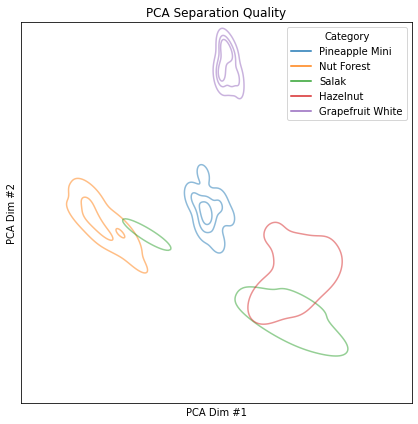

In [14]:
plt.figure(figsize=(7,7))
sns.kdeplot(
    data=df, x="x", y="y", 
    hue="Category", fill=False, levels=4, 
    alpha=.5
)

plt.title('PCA Separation Quality')
plt.xticks([])
plt.yticks([])
plt.xlabel('PCA Dim #1')
plt.ylabel('PCA Dim #2')
plt.show()

In [15]:
# x = pd.Series((x_train[:500].reshape(-1))).value_counts().sort_index()
# x = x[x.index != 255]
# plt.plot(x.index,x.values)

131it [00:04, 27.88it/s]


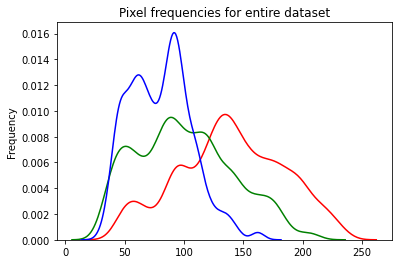

In [16]:
x,_ = get_trainable_arrays(load_data(TRAIN))
r,g,b = x.mean((1,2),where=x <= 253).T

sns.kdeplot(r,color='red')
sns.kdeplot(g,color='green')
sns.kdeplot(b,color='blue')
plt.ylabel('RGB Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel frequencies for entire dataset')
plt.show()

131it [00:00, 3689.49it/s]


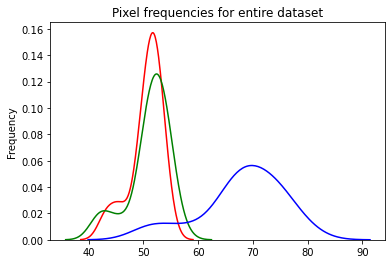

In [17]:
x,_ = get_trainable_arrays(load_data(TRAIN,get_class="Blueberry"))
r,g,b = x.mean((1,2),where=x <= 253).T

sns.kdeplot(r,color='red')
sns.kdeplot(g,color='green')
sns.kdeplot(b,color='blue')
plt.ylabel('RGB Pixel Value')
plt.ylabel('Frequency')
plt.title('Pixel frequencies for entire dataset')
plt.show()

In [18]:
import os
from tqdm import tqdm
train_acc = {}
train_dir = '../input/fruits/fruits-360_dataset/fruits-360/Training'
path, dirs, files = next(os.walk(train_dir))

for dir in tqdm(dirs):
#     path, dirs, files = next(os.walk(path + '/' + dir + '/'))
#     list = os.listdir(path + '/' + dir) # dir is your directory path
    train_acc[dir] = len(os.listdir(path + '/' + dir))

100%|██████████| 131/131 [00:00<00:00, 1529.00it/s]


In [19]:
import os
from tqdm import tqdm
test_acc = {}
test_dir = '../input/fruits/fruits-360_dataset/fruits-360/Test'
path, dirs, files = next(os.walk(test_dir))

for dir in tqdm(dirs):
#     path, dirs, files = next(os.walk(path + '/' + dir + '/'))
#     list = os.listdir(path + '/' + dir) # dir is your directory path
    test_acc[dir] = len(os.listdir(path + '/' + dir))

100%|██████████| 131/131 [00:05<00:00, 24.42it/s]


In [20]:
train_acc = pd.DataFrame(train_acc.items()).set_index(0)
test_acc =  pd.DataFrame(test_acc.items()).set_index(0)

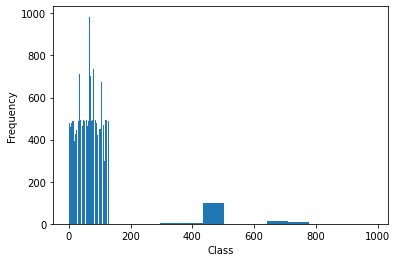

In [21]:
vals = train_acc

import matplotlib.pyplot as plt
import numpy as np

plt.bar(range(len(vals)), height=vals[1])

# plt.hist(vals, density=True, bins=30)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Class');

plt.hist(vals)
# plt.legend('off')
plt.show()

In [22]:
vals[1].describe()

count    131.000000
mean     516.732824
std      107.093620
min      297.000000
25%      471.000000
50%      490.000000
75%      492.000000
max      984.000000
Name: 1, dtype: float64

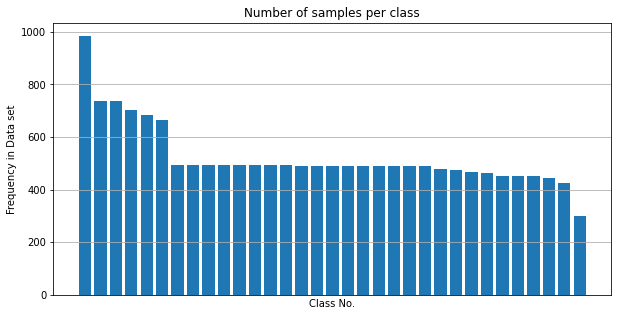

In [23]:
plt.figure(figsize=(10,5))
arr = vals.sort_values(1,ascending=False).values[::4]
plt.title('Number of samples per class')
plt.bar(range(len(arr)), height=arr.T[0], )
plt.ylabel('Frequency in Data set')
plt.xlabel('Class No.');
plt.xticks([])
# plt.xlim([-1,120])
plt.grid('on')
plt.show()

In [24]:
acc

{'Clementine': array([[229.96347092, 107.30109489,  66.80308408],
        [227.01969247, 107.21990266,  58.30778135],
        [226.66861674, 104.62912786,  63.99864231],
        [229.1187964 , 103.1008649 ,  64.48859011],
        [231.571039  , 111.62330245,  58.51135204],
        [229.32416999,  97.22143039,  56.82730618],
        [228.69355914, 112.21737523,  58.57878977],
        [230.40332701, 117.51305289,  63.11410675],
        [228.44905356, 108.02184165,  68.08744058],
        [227.49431149, 104.54866284,  65.26497525],
        [227.2923961 , 108.3791105 ,  57.16947637],
        [231.34500415, 111.2843766 ,  58.84132937],
        [227.10483433, 106.15614293,  66.38214594],
        [231.20237154, 115.33830193,  60.31544833],
        [228.37338656, 108.28314523,  68.19149468],
        [226.86652372, 104.81117769,  67.94015941],
        [230.47819233, 113.96560494,  56.38049501],
        [231.32987359, 114.31963636,  55.52299914],
        [224.58620222, 104.08771281,  66.05570754]

In [25]:
path

'../input/fruits/fruits-360_dataset/fruits-360/Test'

In [26]:
dirs

['Quince',
 'Grapefruit White',
 'Granadilla',
 'Orange',
 'Apple Red 3',
 'Grape White 2',
 'Corn Husk',
 'Tamarillo',
 'Banana Red',
 'Nectarine Flat',
 'Pepper Yellow',
 'Nut Forest',
 'Pear Monster',
 'Fig',
 'Tomato Heart',
 'Onion Red Peeled',
 'Lemon Meyer',
 'Onion Red',
 'Passion Fruit',
 'Cucumber Ripe',
 'Cactus fruit',
 'Tomato not Ripened',
 'Mango Red',
 'Apple Pink Lady',
 'Pomegranate',
 'Plum',
 'Pineapple',
 'Tomato 1',
 'Cherry 2',
 'Apple Red 2',
 'Avocado ripe',
 'Dates',
 'Maracuja',
 'Papaya',
 'Nut Pecan',
 'Pear Stone',
 'Cherry Wax Yellow',
 'Eggplant',
 'Apple Golden 2',
 'Guava',
 'Beetroot',
 'Tomato Maroon',
 'Potato Red',
 'Apple Red Delicious',
 'Cherry Wax Red',
 'Kiwi',
 'Cherry Wax Black',
 'Limes',
 'Cantaloupe 2',
 'Apple Braeburn',
 'Pear',
 'Carambula',
 'Tomato 3',
 'Onion White',
 'Cherry 1',
 'Strawberry',
 'Lychee',
 'Redcurrant',
 'Rambutan',
 'Potato Red Washed',
 'Tomato 4',
 'Hazelnut',
 'Tomato Yellow',
 'Plum 3',
 'Grape White',
 'Pineap

In [27]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers


bl_model = tf.keras.Sequential([
    layers.Lambda(lambda x:x/255.),
    layers.Conv2D(16,4,),
    layers.ReLU(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
bl_model(tf.zeros_like(img,tf.float32)[None,...])
bl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (1, 100, 100, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (1, 97, 97, 16)           784       
_________________________________________________________________
re_lu (ReLU)                 (1, 97, 97, 16)           0         
_________________________________________________________________
global_average_pooling2d (Gl (1, 16)                   0         
_________________________________________________________________
dense (Dense)                (1, 131)                  2227      
Total params: 3,011
Trainable params: 3,011
Non-trainable params: 0
_________________________________________________________________


In [28]:
bl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [29]:
y_train.shape
img.shape

(100, 100, 3)

In [30]:
bl_model.fit(x_train, y_train, 
             epochs=10, 
             validation_split=.3)

2022-03-03 21:43:03.513879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


InvalidArgumentError:  Input to reshape is a tensor with 512 values, but the requested shape has 16
	 [[node gradient_tape/sequential/global_average_pooling2d/Reshape (defined at tmp/ipykernel_34/1860695382.py:3) ]] [Op:__inference_train_function_704]

Function call stack:
train_function


## Pretrained mobilenet

In [ ]:
from tensorflow.keras.applications import efficientnet

pt_model = efficientnet.EfficientNetB0(False,input_shape=(100,100,3))

In [ ]:
pt_model.trainable = False # Freeze lower layers
print(len(pt_model.layers),'layers in total')
for layer in pt_model.layers[:-10:-1]:
    layer.trainable = True # Unfreeze top 10 layers

In [ ]:
pt_model(x_train[:1])

In [ ]:
pt_model = keras.Sequential([
    layers.Lambda(efficientnet.preprocess_input,),
    pt_model,
    layers.GlobalAvgPool2D(),
    layers.Dropout(.1),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
pt_model(x_train[:1])
pt_model.summary()

In [ ]:
pt_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['acc'],
)

In [ ]:
x_train, y_train = get_trainable_arrays(load_data(TRAIN,sample=30))

In [ ]:
pt_model.optimizer.lr = 1e-4
pt_model.fit(x_train, y_train, 
             epochs=5, 
             validation_split=.3)
pt_model.optimizer.lr = 1e-5